This is a notebook for plotting the development of the prominence of the rhythm of a bee and the share of beeing circadian over different age groups.

# Imports

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import datetime
import pytz
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import ticker
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import scipy
import typing

import bb_rhythm.plotting
import bb_rhythm.utils

In [4]:
sns.set_style("ticks")
sns.set_palette(sns.color_palette("colorblind"))
matplotlib.rcParams.update({'font.size': 5, 'ytick.major.size': 1,
                                'ytick.major.width': 0.4, 'font.sans-serif': 'Arial'})

# 2019

## data

In [6]:
dist = pd.read_pickle("../../plots/pivot_dist_plot.pkl")
dist.columns = dist.columns.map(lambda x: x[0] + "_" + x[1] if len(x[1]) > 0 else x[0])

In [8]:
# cosinor fit data for period 2019
df_2019 = pd.read_pickle("../../diurnal_rhythm_paper/data/dataframes/circadianess_2019/cosinor_3600.pkl")

# define bees being circadian with results of zero amplitude test being < 0.05
df_2019["is_circadian"] = df_2019.p_value < 0.05

In [10]:
# movement speeds
velocity_df_2019 = pd.read_pickle(
    "../../diurnal_rhythm_paper/data/dataframes/velocity_weather_over_time_2019/velocity_mean_10min_all_bb2019_bayesian_bees.pkl")
velocities_young = pd.read_pickle("../../plots/5101.pkl")
velocities_old = pd.read_pickle("../../plots/2088.pkl")

## a)

In [27]:
# get velocity old data
def extract_estimates_from_cosinor_df(bee_id: int, day: datetime.datetime, cosinor_df: pd.DataFrame) -> tuple[float, float, float]:
    query_mask = (cosinor_df.bee_id == bee_id) & (cosinor_df.date == day)
    M = cosinor_df[query_mask].mesor.values[0]
    A = cosinor_df[query_mask].amplitude.values[0]
    P = cosinor_df[query_mask].phase.values[0]
    return M, A, P

def median_cosinor_fit(velocity_df: pd.DataFrame, M: float, A: float, P: float, round_up_to: str, day: datetime.datetime) -> tuple[pd.DataFrame, pd.DataFrame, np.array]:
    # get median fit old data
    velocity_df["datetime"] = velocity_df["datetime"].dt.round(round_up_to)
    velocity_median_df = velocity_df.groupby(["datetime"])[["velocity", "time_passed"]].median().reset_index()
    X = np.array([t.total_seconds() for t in velocity_df.datetime - day])
    Y = A*np.cos(X-P) + M
    return velocity_df, velocity_median_df, Y

In [28]:
# add age bins
binning = bb_rhythm.utils.Binning(bin_name="Age [days]", bin_parameter="age")
df_2019_plt = binning.add_bins_to_df(df_2019.dropna(), bins=[0, 4, 9, 14, 19, 24, 29, 34], step_size=None)
binning = bb_rhythm.utils.Binning(bin_name="Age [days]", bin_parameter="age")
velocity_df_2019 = binning.add_bins_to_df(velocity_df_2019, bins=[0, 4, 9, 14, 19, 24, 29, 34])

# create color palette from age bins
palette = bb_rhythm.plotting.create_age_color_palette(
        sorted(df_2019_plt["Age [days]"].unique()), "Age [days]", df_2019_plt
    )

# get speed subset from time window
dt_from = pd.to_datetime(datetime.datetime(2019, 9, 11), utc=True)
dt_to = pd.to_datetime(datetime.datetime(2019, 9, 14), utc=True)
velocity_df_2019_subperiod = velocity_df_2019[((velocity_df_2019["date"] >= dt_from) & (velocity_df_2019["date"] < dt_to))]

/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, self.bin_name] = [self.bin_labels[item] for item in self.bins]
/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/utils.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=[self.bin_name], inplace=True)


/home/julia/arbeit/hiveopolis/bb_rhythm/bb_rhythm/plotting.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_age_velocity_df.loc[:, "velocity_smoothed"] = time_age_velocity_df["velocity"]


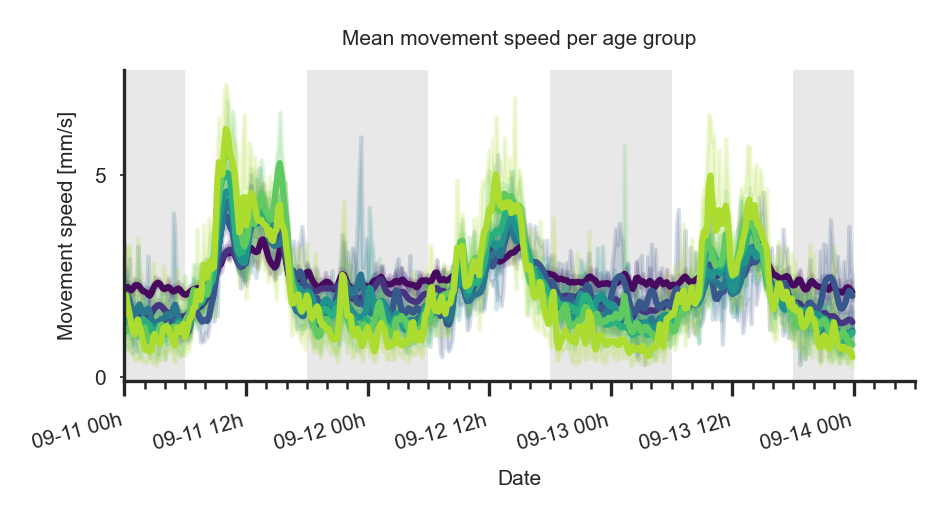

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(3.4, 1.35), dpi=300)

# add grey bars indicating nighttime
bb_rhythm.plotting.add_grey_nighttime_bars(axs, velocity_df_2019_subperiod)

# plot smoothed velocities
bb_rhythm.plotting.plot_smoothed_age_velocity_over_time(
    axs, 
    palette, 
    "Age [days]", 
    velocity_df_2019_subperiod, 
    hue_order=sorted(df_2019_plt["Age [days]"].unique())
)

# x-axis settings
axs.set_xlim(dt_from, dt_to + datetime.timedelta(hours=6))
date_form = matplotlib.dates.DateFormatter("%m-%d %Hh")
axs.xaxis.set_major_formatter(date_form)
axs.xaxis.set_minor_locator(mdates.HourLocator(byhour=[2, 4, 6, 8, 10, 14, 16, 18, 20, 22]))
axs.set_xlabel("Date")
axs.set_xticks(axs.get_xticks().tolist())
axs.set_xticklabels(axs.get_xticklabels(), rotation=15, ha='right')

# y-axis settings
axs.set_ylabel('Movement speed [mm/s]')
axs.yaxis.set_major_locator(ticker.MultipleLocator(5))

# legend settings
axs.legend().remove()

# figure settings
axs.set_title("Mean movement speed per age group", fontsize=rcParams['axes.labelsize'])
axs.tick_params(which='minor', length=2)
sns.despine(ax=axs)

# save fig
plt.savefig("panel_2_a.svg", bbox_inches="tight")
plt.savefig("panel_2_a.png", bbox_inches="tight")

## b)

In [53]:
day = datetime.datetime(2019, 9, 12, 12, tzinfo=pytz.utc)
round_up_to = '3600s'
ylim = (-0.5, 12.6)

In [67]:
def plot_cosinor_with_velocities(ax: matplotlib.axes.Axes, velocity_df: pd.DataFrame, velocity_subperiod_df: pd.DataFrame, color, day, cosinor_df, bee_id, round_up_to, ylim, set_xticks=True):
    # get fit estimates
    M, A, P = extract_estimates_from_cosinor_df(bee_id, day, cosinor_df)
    
    # get median fit
    velocity_df, velocity_median_df, Y = median_cosinor_fit(velocity_df, M, A, P, round_up_to, day)

    # add grey nighttimes
    bb_rhythm.plotting.add_grey_nighttime_bars(ax, velocity_subperiod_df)
    
    # plot cosinor fit
    sns.lineplot(x=velocity_df.datetime.values, y=Y, c=color, label="Cosinor model", ax=ax, linestyle="--")
    # plot 95% percentile velocities
    sns.lineplot(
          data=velocity_df, x="datetime", y="velocity",
          errorbar=("pi", 90),
          color=color, ax=ax, label="Movement speed", estimator="median", linewidth=0,
    )
    # plot median velocities
    sns.scatterplot(velocity_median_df, x="datetime", y="velocity", color=color, marker="X", size=0.75, ax=ax, label="Median movement\nspeed per h")
    
    # x-axis settings
    ax.set_xlim(velocity_subperiod_df.date.min(), velocity_subperiod_df.date.max() + datetime.timedelta(hours=6))
    ax.set_xlabel("Date")
    if set_xticks:
        date_form = matplotlib.dates.DateFormatter("%m-%d %Hh")
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[2, 4, 6, 8, 10, 14, 16, 18, 20, 22]))
        ax.set_xticks(ax.get_xticks().tolist())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
    
    # y-axis settings
    ax.set_ylim(ylim)
    ax.set_ylabel("Movement speed [mm/s]")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    
    # figure settings
    ax.tick_params(which='minor', length=2)

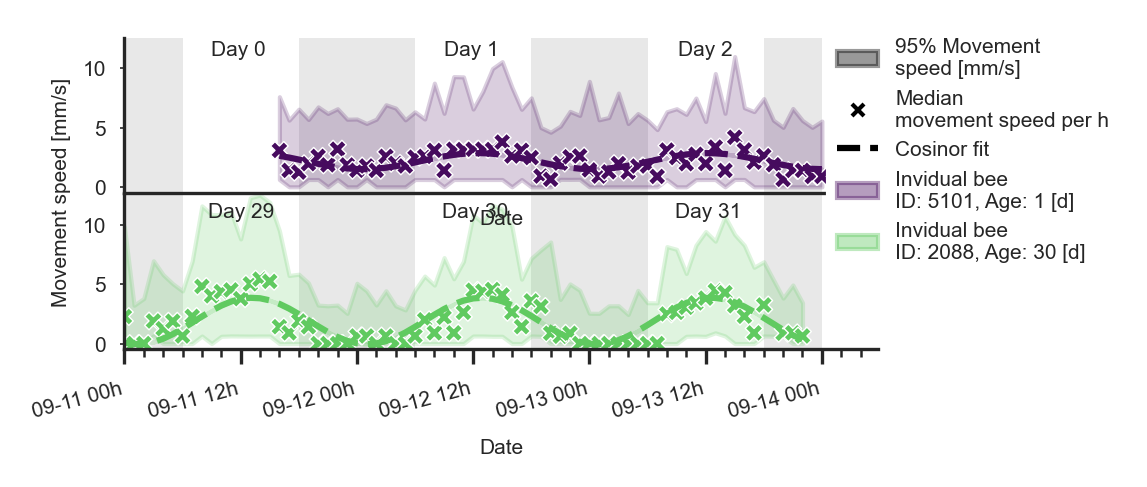

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(3.243, 1.35), gridspec_kw={'height_ratios': [0.5, 0.5], 'hspace': 0.01}, dpi=300)

# plot cosinor fit
plot_cosinor_with_velocities(axs[0], velocities_young, velocity_df_2019_subperiod, palette[0], day, df_2019, 5101, round_up_to, ylim, set_xticks=False)
plot_cosinor_with_velocities(axs[1], velocities_old, velocity_df_2019_subperiod, palette[6], day, df_2019, 2088, round_up_to, ylim)

# x-axis settings
axs[0].set_xticks([]) 
axs[0].set_xticklabels([])
axs[0].tick_params(bottom=False) 

# y-axis settings
axs[0].set_ylabel("")
axs[1].set_ylabel("")

# legend settings
legends = [
    (mpatches.Patch(color='black', alpha=0.4), '95% Movement\nspeed [mm/s]'), 
    ((mlines.Line2D([], [], color='black', marker='x', linewidth=0, markersize=3)), "Median\nmovement speed per h"), 
    ((mlines.Line2D([], [], color='black', linestyle='--')), 'Cosinor fit'),
    (mpatches.Patch(color=palette[0], alpha=0.4), 'Invidual bee\nID: 5101, Age: 1 [d]'),
    (mpatches.Patch(color=palette[6], alpha=0.4), 'Invidual bee\nID: 2088, Age: 30 [d]'),
]
leg = axs[0].legend(*zip(*legends), loc='center left', bbox_to_anchor=(0.92, 0.275), framealpha=1.0, edgecolor=(1.0, 1.0, 1.0, 1.0))
axs[1].set_zorder(-1)
axs[1].get_legend().remove()

# add day information to plot
fig.text(0.245, 0.85, 'Day 0 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.485, 0.85, 'Day 1 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.725, 0.85, 'Day 2 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.245, 0.45, 'Day 29', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.485, 0.45, 'Day 30', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.725, 0.45, 'Day 31', va='center', ha='center', fontsize=rcParams['axes.labelsize'])

# plot settings
fig.text(0.06, 0.5, 'Movement speed [mm/s]', va='center', ha='center', fontsize=rcParams['axes.labelsize'], rotation='vertical')
sns.despine()

# save fig
plt.savefig("panel_2_b.svg")
plt.savefig("panel_2_b.png")

/home/julia/anaconda3/envs/marie_test/lib/python3.11/site-packages/seaborn/relational.py:573: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(x=x, y=y, **kws)
/tmp/ipykernel_60806/2072550278.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=15, ha='right')


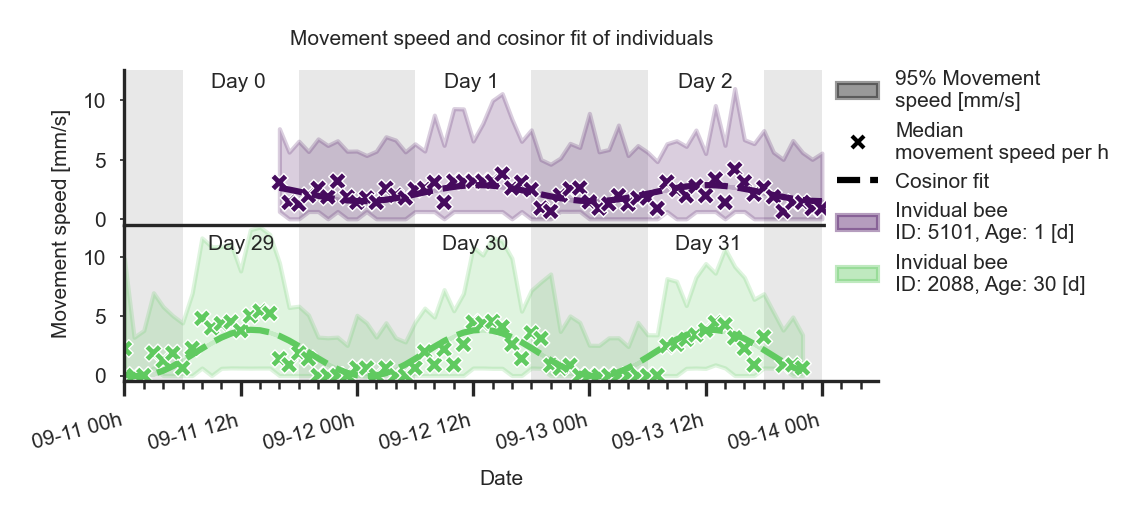

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(3.243, 1.35), gridspec_kw={'height_ratios': [0.5, 0.5], 'hspace': 0.01}, dpi=300)

# add grey nighttimes
bb_rhythm.plotting.add_grey_nighttime_bars(axs[0], velocity_df_2019_subperiod)
# plot cosinor fit
sns.lineplot(x=velocities_young.datetime.values, y=y_young, c=palette[0], label="Cosinor model", ax=axs[0], linestyle="--")
# plot 95% percentile velocities
sns.lineplot(
      data=velocities_young, x="datetime", y="velocity",
      errorbar=("pi", 90),
      color=palette[0], ax=axs[0], label="Movement speed", estimator="median", linewidth=0,
)
# plot median velocities
sns.scatterplot(velocities_young_median, x="datetime", y="velocity", c=palette[0], marker="X", size=0.75, ax=axs[0], label="Median movement\nspeed per h")
axs[0].set_xlim(velocity_df_2019_subperiod.date.min(), velocity_df_2019_subperiod.date.max() + datetime.timedelta(hours=6))
axs[0].set_ylim(-0.5, 12.6)
axs[0].set_ylabel("")

# add grey nightimes
bb_rhythm.plotting.add_grey_nighttime_bars(axs[1], velocity_df_2019_subperiod)
# plot cosinor fit
sns.lineplot(x=velocities_old.datetime.values, y=y_old, color=palette[6], label="Cosinor model", ax=axs[1], linestyle="--")
# plot 95% percentile velocities
sns.lineplot(     
     data=velocities_old, x="datetime", y="velocity",
      errorbar=("pi", 90),
      color=palette[6], ax=axs[1], label="Movement speed", estimator="median", linewidth=0,
 )
# plot median velocities
sns.scatterplot(velocities_old_median, x="datetime", y="velocity", color=palette[6], marker="X", size=0.75, ax=axs[1], label="Median movement\nspeed per h")

date_form = matplotlib.dates.DateFormatter("%m-%d %Hh")
axs[1].xaxis.set_major_formatter(date_form)
axs[1].set_ylim(-0.5, 12.6)
axs[1].set_xlim(velocity_df_2019_subperiod.date.min(), velocity_df_2019_subperiod.date.max() + datetime.timedelta(hours=6))
axs[0].set_ylabel("")
axs[1].set_xlabel("Date")
axs[0].set_xlabel("")
axs[0].set_title("Movement speed and cosinor fit of individuals", fontsize=rcParams['axes.labelsize'])
axs[1].xaxis.set_minor_locator(mdates.HourLocator(byhour=[2, 4, 6, 8, 10, 14, 16, 18, 20, 22]))
axs[1].tick_params(which='minor', length=2)
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=15, ha='right')

legends = [
    (mpatches.Patch(color='black', alpha=0.4), '95% Movement\nspeed [mm/s]'), 
    ((mlines.Line2D([], [], color='black', marker='x', linewidth=0, markersize=3)), "Median\nmovement speed per h"), 
    ((mlines.Line2D([], [], color='black', linestyle='--')), 'Cosinor fit'),
    (mpatches.Patch(color=palette[0], alpha=0.4), 'Invidual bee\nID: 5101, Age: 1 [d]'),
    (mpatches.Patch(color=palette[6], alpha=0.4), 'Invidual bee\nID: 2088, Age: 30 [d]'),
]
leg = axs[0].legend(*zip(*legends), loc='center left', bbox_to_anchor=(0.92, 0.275), framealpha=1.0, edgecolor=(1.0, 1.0, 1.0, 1.0))
axs[1].set_zorder(-1)
axs[0].tick_params(bottom = False) 
axs[0].set_xticks([]) 
axs[1].get_legend().remove()

# add day innformation to plot
fig.text(0.245, 0.85, 'Day 0 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.485, 0.85, 'Day 1 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.725, 0.85, 'Day 2 ', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.245, 0.45, 'Day 29', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.485, 0.45, 'Day 30', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.725, 0.45, 'Day 31', va='center', ha='center', fontsize=rcParams['axes.labelsize'])

# plot settings
fig.text(0.06, 0.5, 'Movement speed [mm/s]', va='center', ha='center', fontsize=rcParams['axes.labelsize'], rotation='vertical')
sns.despine()

# save fig
plt.savefig("panel_2_b.svg")
plt.savefig("panel_2_b.png")

## c)

In [51]:
dist = pd.read_pickle("../../plots/pivot_dist_plot.pkl")
dist.columns = dist.columns.map(lambda x: x[0] + "_" + x[1] if len(x[1]) > 0 else x[0])
dist["x_pos_start_focal"] = dist["x_pos_start_focal"].round()
dist["y_pos_start_focal"] = dist["y_pos_start_focal"].round()
frame = cv2.imread('../../plots/frame.png')
entrance_coordinates = (5, 264)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(3.24, 1.35), dpi=300)
axs.imshow(scipy.ndimage.zoom(frame[:, :, 0], 0.1), cmap='gray', vmin=0, vmax=255)
axs.text(10, 270, 'Exit', va='top', ha='left', fontsize=rcParams['axes.labelsize'])
axs.arrow(x=5 + 15, y=264 - 15, dx=-15, dy=15, color='red', zorder=10, width=5)
sns.despine(ax=axs)
axs.set_xlabel("X-position [mm]")
axs.set_ylabel("Y-position [mm]")
x = "y_pos_start_focal"
y = "x_pos_start_focal"
dist_90 = dist.copy()
pivot_90 = dist.pivot_table(index=x, columns=y, values="age_focal_median", aggfunc=np.nanmedian, dropna=False)
X, Y = np.meshgrid(sorted(dist.x_pos_start_focal.unique()), sorted(dist.y_pos_start_focal.unique()))
Z = pivot_90
Z = gaussian_filter(Z, 3)
cp = axs.contourf(X, Y, Z, cmap='viridis', levels=[0, 5, 10, 15, 20, 25, 30, 35, 40], alpha=0.4)
cp = axs.contour(X, Y, Z, cmap='viridis', levels=[0, 5, 10, 15, 20, 25, 30, 35, 40], alpha=1.0)
axs.xaxis.set_major_locator(ticker.MultipleLocator(50))
axs.set_title("Median Age [d]", fontsize=rcParams['axes.labelsize'])
plt.savefig("plot_1_c.svg")

## d)

In [12]:
# bar plot frame
df_bar = df_2019_plt.groupby(["Age [days]"]).agg(
     no=("is_circadian", lambda x: 100),
     yes=("is_circadian", lambda x: x.sum() / x.count() * 100),
).rename(columns={"yes": "Circadian", "no": "Non-circadian"}).reset_index()

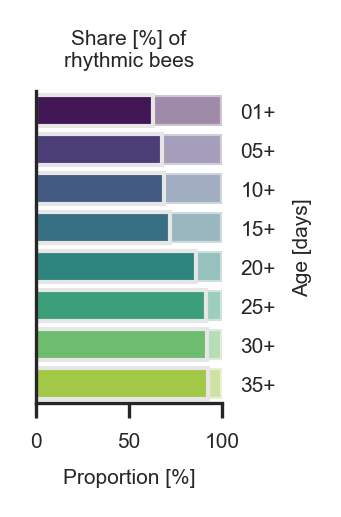

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(0.8, 1.35), dpi=300)

# barplot
sns.barplot(data=df_bar, y="Age [days]", x="Non-circadian", ax=axs, palette=palette, order=sorted(df_2019_plt["Age [days]"].unique()), alpha=0.5)
sns.barplot(data=df_bar, y="Age [days]", x="Circadian", ax=axs, palette=palette, order=sorted(df_2019_plt["Age [days]"].unique()), edgecolor=".9")

# x-axis settings
axs.set_xlabel("Proportion [%]")
axs.set_xlim(0, 100.0)

# y-axis settings
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.tick_params(right=False)

# figure settings
axs.set_title("Share [%] of\nrhythmic bees", fontsize=rcParams['axes.labelsize'])
sns.despine(ax=axs)
axs.grid(False)

# save
plt.savefig("panel_2_d.svg")

## e)

In [4]:
dist["entrance_dist_focal_median_round"] = dist["entrance_dist_focal_median"].round(-1)
dist = dist.groupby(["entrance_dist_focal_median_round"]).median().reset_index()
dist["phase_focal_q"] = 100 - pd.qcut(dist["phase_focal_median"], 100, labels=False, duplicates="drop",
                                      retbins=True)[0]
dist["phase_focal_std_q"] = 100 - pd.qcut(dist["phase_focal_std"], 100, labels=False, duplicates="drop", retbins=True)[
    0]
dist["age_focal_q"] = pd.qcut(dist["age_focal_median"], 100, labels=False, duplicates="drop", retbins=True)[0]
dist["r_squared_focal_q"] = pd.qcut(dist["r_squared_focal_median"], 100, labels=False,
                                    duplicates="drop", retbins=True)[0]
dist = dist[dist["phase_focal_count"] > dist["phase_focal_count"].quantile(0.05)]
dist["r_squared_focal_median_round"] = dist["r_squared_focal_median"].round(2)
dist = dist[dist["phase_focal_count"] > dist["phase_focal_count"].quantile(0.05)]
dist["entrance_dist_focal_median_round"] = dist["entrance_dist_focal_median"].round(-1)
dist = dist.groupby(["entrance_dist_focal_median_round"]).median().reset_index()
dist["phase_focal_q"] = 1 - (dist["phase_focal_median"] - dist["phase_focal_median"].min()) / (
            dist["phase_focal_median"].max() - dist["phase_focal_median"].min())
dist["phase_focal_std_q"] = 1 - (dist["phase_focal_std"] - dist["phase_focal_std"].min()) / (
            dist["phase_focal_std"].max() - dist["phase_focal_std"].min())
dist["age_focal_q"] = (dist["age_focal_median"] - dist["age_focal_median"].min()) / (
            dist["age_focal_median"].max() - dist["age_focal_median"].min())
dist["r_squared_focal_q"] = (dist["r_squared_focal_median"] - dist["r_squared_focal_median"].min()) / (
            dist["r_squared_focal_median"].max() - dist["r_squared_focal_median"].min())
dist["phase_focal_count_q"] = 1 - (dist["phase_focal_count"] - dist["phase_focal_count"].min()) / (
            dist["phase_focal_count"].max() - dist["phase_focal_count"].min())

NameError: name 'dist' is not defined

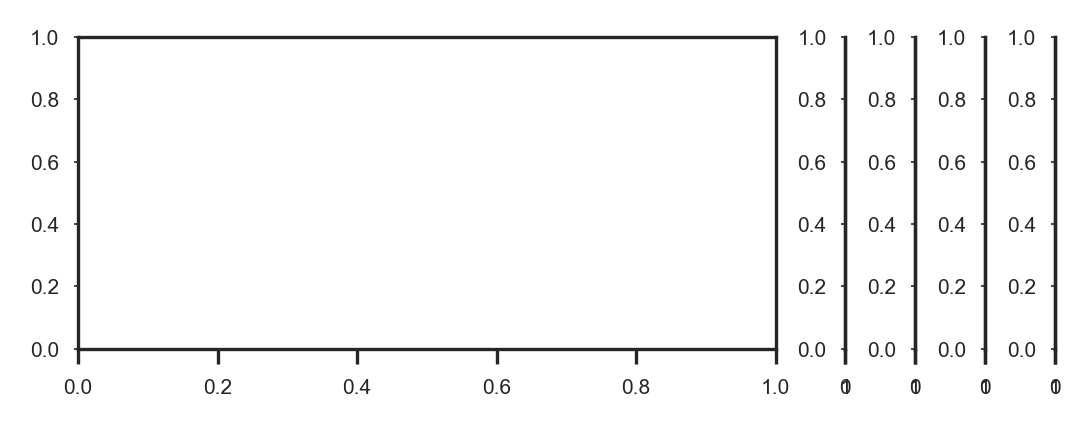

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(4.2, 1.35), gridspec_kw={"width_ratios":[1.0, 0.0, 0.0, 0.0, 0.0], "wspace": 0.5}, dpi=300)

# plot lines
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="phase_focal_q", ax=axs[0], estimator="median", errorbar=None,
             label="Phase Median", markers=True)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="phase_focal_std_q", ax=axs[0], estimator="median",
             errorbar=None,
             label="Phase Std", linestyle="dotted", markers=True, dashes=False)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="age_focal_q", ax=axs[0], estimator="median", errorbar=None,
             label="Age Median", linestyle="dashed", markers=True, dashes=False)
sns.lineplot(dist, x="entrance_dist_focal_median_round", y="r_squared_focal_q", ax=axs[0], estimator="median",
             errorbar=None, label="R² Median", linestyle="dashdot", markers=True, dashes=False)

# whiten out areas with low sample sizes
bb_rhythm.plotting.whiten_out_low_sample_size_areas(axs[0], dist, "entrance_dist_focal_median_round", "phase_focal_count_q")

# x-axis settings
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(50))
axs[0].set_xlim(0, dist["entrance_dist_focal_median_round"].max())
axs[0].set_xlabel("Distance to exit [mm]")
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(50))

# y-axis settings
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='y', which='major', pad=1)
axs[0].set_ylabel("Phase Median/ Phase Std/ Age Median/\nR² Median (Min-Max Normalized)")

# legend settings
axs[0].legend(frameon=False, loc='upper right')

# figure settings
sns.despine(ax=axs[0])
axs[0].tick_params(which='minor', length=2)
axs[0].set_title("Rhythm Parameters at distances to exit", fontsize=rcParams['axes.labelsize'])

# multiple axis settings
## phase
axs[1].get_xaxis().set_visible(False)
sns.despine(ax=axs[1])
axs[1].set_yticks(axs[1].get_yticks().tolist())
axs[1].set_yticklabels([np.round(i / 10 * dist["phase_focal_median"].min() + dist["phase_focal_median"].max() * (-i / 10) + dist["phase_focal_median"].max(), 1) for i in range(0, 12, 2)])
axs[1].tick_params(axis='y', which='major', pad=1)
axs[1].set_title("P", fontsize=rcParams['axes.labelsize'])
axs[1].yaxis.set_label_position("right")

## phase std
axs[2].get_xaxis().set_visible(False)
axs[2].set_yticks(axs[2].get_yticks().tolist())
axs[2].set_yticklabels([np.round(i / 10 * dist["phase_focal_std"].min() + dist["phase_focal_std"].max() * (-i / 10) + dist["phase_focal_std"].max(), 1) for i in range(0, 12, 2)])
axs[2].tick_params(axis='y', which='major', pad=1)
axs[2].set_title("PStd", fontsize=rcParams['axes.labelsize'])
axs[2].yaxis.set_label_position("right")

## age
axs[3].get_xaxis().set_visible(False)
axs[3].set_yticks(axs[3].get_yticks().tolist())
axs[3].set_yticklabels([np.round(-(i / 10 - 1) * dist["age_focal_median"].min() + dist["age_focal_median"].max() * (i / 10), 1) for i in range(0, 12, 2)])
axs[3].tick_params(axis='y', which='major', pad=1)
axs[3].set_title("Age", fontsize=rcParams['axes.labelsize'])
axs[3].yaxis.set_label_position("right")

## R²
axs[4].get_xaxis().set_visible(False)
axs[4].set_yticks(axs[4].get_yticks().tolist())
axs[4].set_yticklabels([np.round(-(i / 10 - 1) * dist["r_squared_focal_median"].min() + dist["r_squared_focal_median"].max() * (i / 10), 2) for i in range(0, 12, 2)])
axs[4].tick_params(axis='y', which='major', pad=1)
axs[4].set_title("R²", fontsize=rcParams['axes.labelsize'])
axs[4].yaxis.set_label_position("right")

# save figure
plt.savefig("panel_2_e.svg", bbox_inches="tight")
plt.savefig("panel_2_e.png", bbox_inches="tight")